# Get Krispy Kreme locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import os
import requests
import json

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1020
pd.options.display.max_colwidth = None

---

## Read data

#### Get details about each location from it's [shops page](https://www.krispykreme.com/locate/location-search), using the [geographic center](https://www.google.com/maps/@44.9672148,-103.7715692,3a,75y,100.51h,71.95t/data=!3m8!1e1!3m6!1sAF1QipPp6UZuzxh0siwSLTrzZM_BXynRC4kFhK8sr6i0!2e10!3e11!6shttps:%2F%2Flh5.googleusercontent.com%2Fp%2FAF1QipPp6UZuzxh0siwSLTrzZM_BXynRC4kFhK8sr6i0%3Dw203-h100-k-no-pi2.8988364-ya302.28113-ro-3.8397105-fo100!7i5376!8i2688?hl=en&entry=ttu) of the US

In [4]:
shops_url = "https://api.krispykreme.com/shops/?latitude=44.9672148&longitude=-103.7715692&count=10000&shopFeatureFlags=0&includeGroceryStores=false&includeShops=true"
grocery_url = "https://api.krispykreme.com/shops/?latitude=44.9672148&longitude=-103.7715692&count=10000&shopFeatureFlags=0&includeGroceryStores=true&includeShops=false"

#### The locations are in stand-alone shops or kiosks in grocery stores

In [5]:
shops_response = requests.get(shops_url)
grocery_response = requests.get(grocery_url)

#### Read both into dataframes

In [6]:
shops_src = pd.DataFrame(shops_response.json())
grocery_src = pd.DataFrame(grocery_response.json())

#### Tag them with types

In [7]:
shops_src["type"] = "shop"
grocery_src["type"] = "grocery"

#### Concatenate into one large dataframe without camelCase headers

In [8]:
src = pd.concat([grocery_src, shops_src]).rename(columns={"address1": "street_address"})

In [9]:
src.columns = src.columns.str.lower()

In [10]:
src["street_address"] = src["street_address"].str.title()
src["shop_name"] = src["street_address"].str.title()

#### There are so many columns we probably don't need, but you never know: 

In [11]:
src.columns

Index(['siteid', 'shopid', 'shopname', 'shopurl', 'street_address', 'address2',
       'city', 'state', 'zipcode', 'phonenumber', 'faxnumber', 'emails',
       'latitude', 'longitude', 'isclosed', 'hoursdescription',
       'hoursdescriptiondinein', 'hoursdescriptiondrivethru',
       'hoursdescriptionhotlight', 'hoursdescriptiondelivery', 'hoursdinein',
       'hoursdrivethru', 'hourshotlight', 'hoursdelivery', 'shorthoursdinein',
       'shorthoursdrivethru', 'shorthourshotlight', 'shorthoursdelivery',
       'distance', 'hotlighton', 'locationid', 'locationtype',
       'excludefrompromo', 'oloid', 'canpickup', 'candeliver', 'hasfullecomm',
       'haswhitelabel', 'supportsdispatch', 'supportstip', 'whitelabelurl',
       'whitelabelmobileurl', 'facebookpageurl', 'careersurl',
       'fundraisingtype', 'fundraisingpricingurl',
       'fundraisingpricingimageurl', 'fundraisingbrochures',
       'fundraisingofflinecustommessage', 'fundraisingonlinecustommessage',
       'hasadvancedor

#### Make a clean dataframe from those we need now

In [12]:
df = src[
    [
        "shopid",
        "shopname",
        "street_address",
        "city",
        "state",
        "zipcode",
        "latitude",
        "longitude",
        "type",
    ]
].copy()

#### The result: 

In [13]:
df.head()

,shopid,shopname,street_address,city,state,zipcode,latitude,longitude,type
0,4010,WALMART #4599,4500 Weitzel St,Timnath,CO,80547,40.526543,-104.990433,grocery
1,949,KING SOOPERS #104,1520 Main St,Windsor,CO,80550,40.481430,-104.927612,grocery
2,4041,WALMART #5051,920 47Th Ave,Greeley,CO,80634,40.422749,-104.754700,grocery
3,3239,WALMART #1008,250 W 65Th St,Loveland,CO,80538,40.456879,-105.080978,grocery
4,3220,WALMART #0953,1325 Denver Ave,Loveland,CO,80537,40.404419,-105.046631,grocery


In [14]:
len(df)

4646

---

## Geography

#### Geodataframe from lon/lat

In [15]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

#### Plot it

<AxesSubplot: >

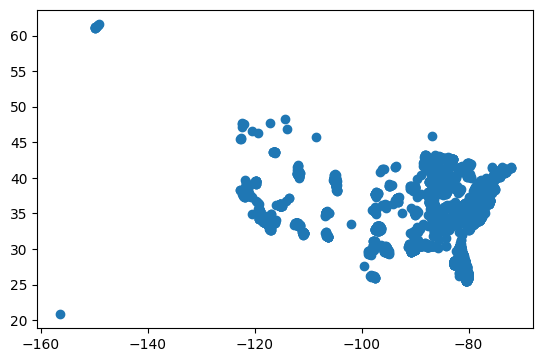

In [16]:
gdf.plot()

---

## Exports

In [17]:
gdf.to_file("data/processed/krispykreme.geojson", driver="GeoJSON")

In [18]:
df = df.drop(["geometry"], axis=1)

In [19]:
df.to_json("data/processed/krispykreme.json", orient="records", indent=4)

In [20]:
df.to_csv("data/processed/krispykreme.csv", index=False)